# Predicting House Prices

[House Price Dataset from Kaggle](https://www.google.com/url?q=https://github.com/ktdawood/Thinkful/blob/master/Challenge-%2520Solving%2520Regression%2520Problems.ipynb&source=gmail&ust=1581988757897000&usg=AFQjCNE19Cf81R4rkkCQKWbvCeymrom1ug)

## The scenario

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.
The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.
In this challenge, you are required to improve your model with respect to its prediction performance.


### To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.
**Steps**

* Load the houseprices data from Thinkful's database.
* Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
* Now, split your data into train and test sets where 20% of the data resides in the test set.
* Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
* Evaluate your best model on the test set.
* So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [0]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [0]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [0]:
df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


As we can see, there are plenty of object type variable. If they are considered as features we will have to convert them to numerical values.

# Missing data

### Algorithm
* Pick the features that has high correlation > 35% threshold, drop the other features
* Choose the top 15 numeric variables that has high correlation.
* Pick top three non-numeric variables that has high correlation.

In [0]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


In [0]:
for col in df.columns:
    if df[col].isna().any():
        df = df.drop(columns=col)

In [0]:
df.head()

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


####  As we have plenty of other features to predict the house pricing, it is better to leave the missing data as it is unless you want to work on them exclusively.

# Exploratory data analysis and feature selection

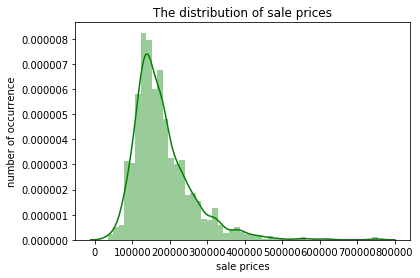

In [0]:
ax = sns.distplot(df.saleprice, color='g')
ax.set_title("The distribution of sale prices")
ax.set_xlabel("sale prices")
ax.set_ylabel("number of occurrence")
plt.show()

The distribution seems non-normal and a little skewed to the left.

### Numeric columns from the dataset:

In [0]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf',
       'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars',
       'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch',
       'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold',
       'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 35


### Since we are dealing with saleprice as the target variable, let's get the top 15 numerical variables that are correlated with saleprice.

In [0]:
np.abs(df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False).head(16)

saleprice       1.000000
overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
firstflrsf      0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
yearremodadd    0.507101
fireplaces      0.466929
bsmtfinsf1      0.386420
wooddecksf      0.324413
secondflrsf     0.319334
openporchsf     0.315856
Name: saleprice, dtype: float64

### Now let's get the non numeric variables from the data:

In [0]:
non_numeric_columns = df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'exterqual', 'extercond', 'foundation', 'heating',
       'heatingqc', 'centralair', 'kitchenqual', 'functional', 'paveddrive',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 27


Let's plot the non numerical values to check their correlation with saleprice.

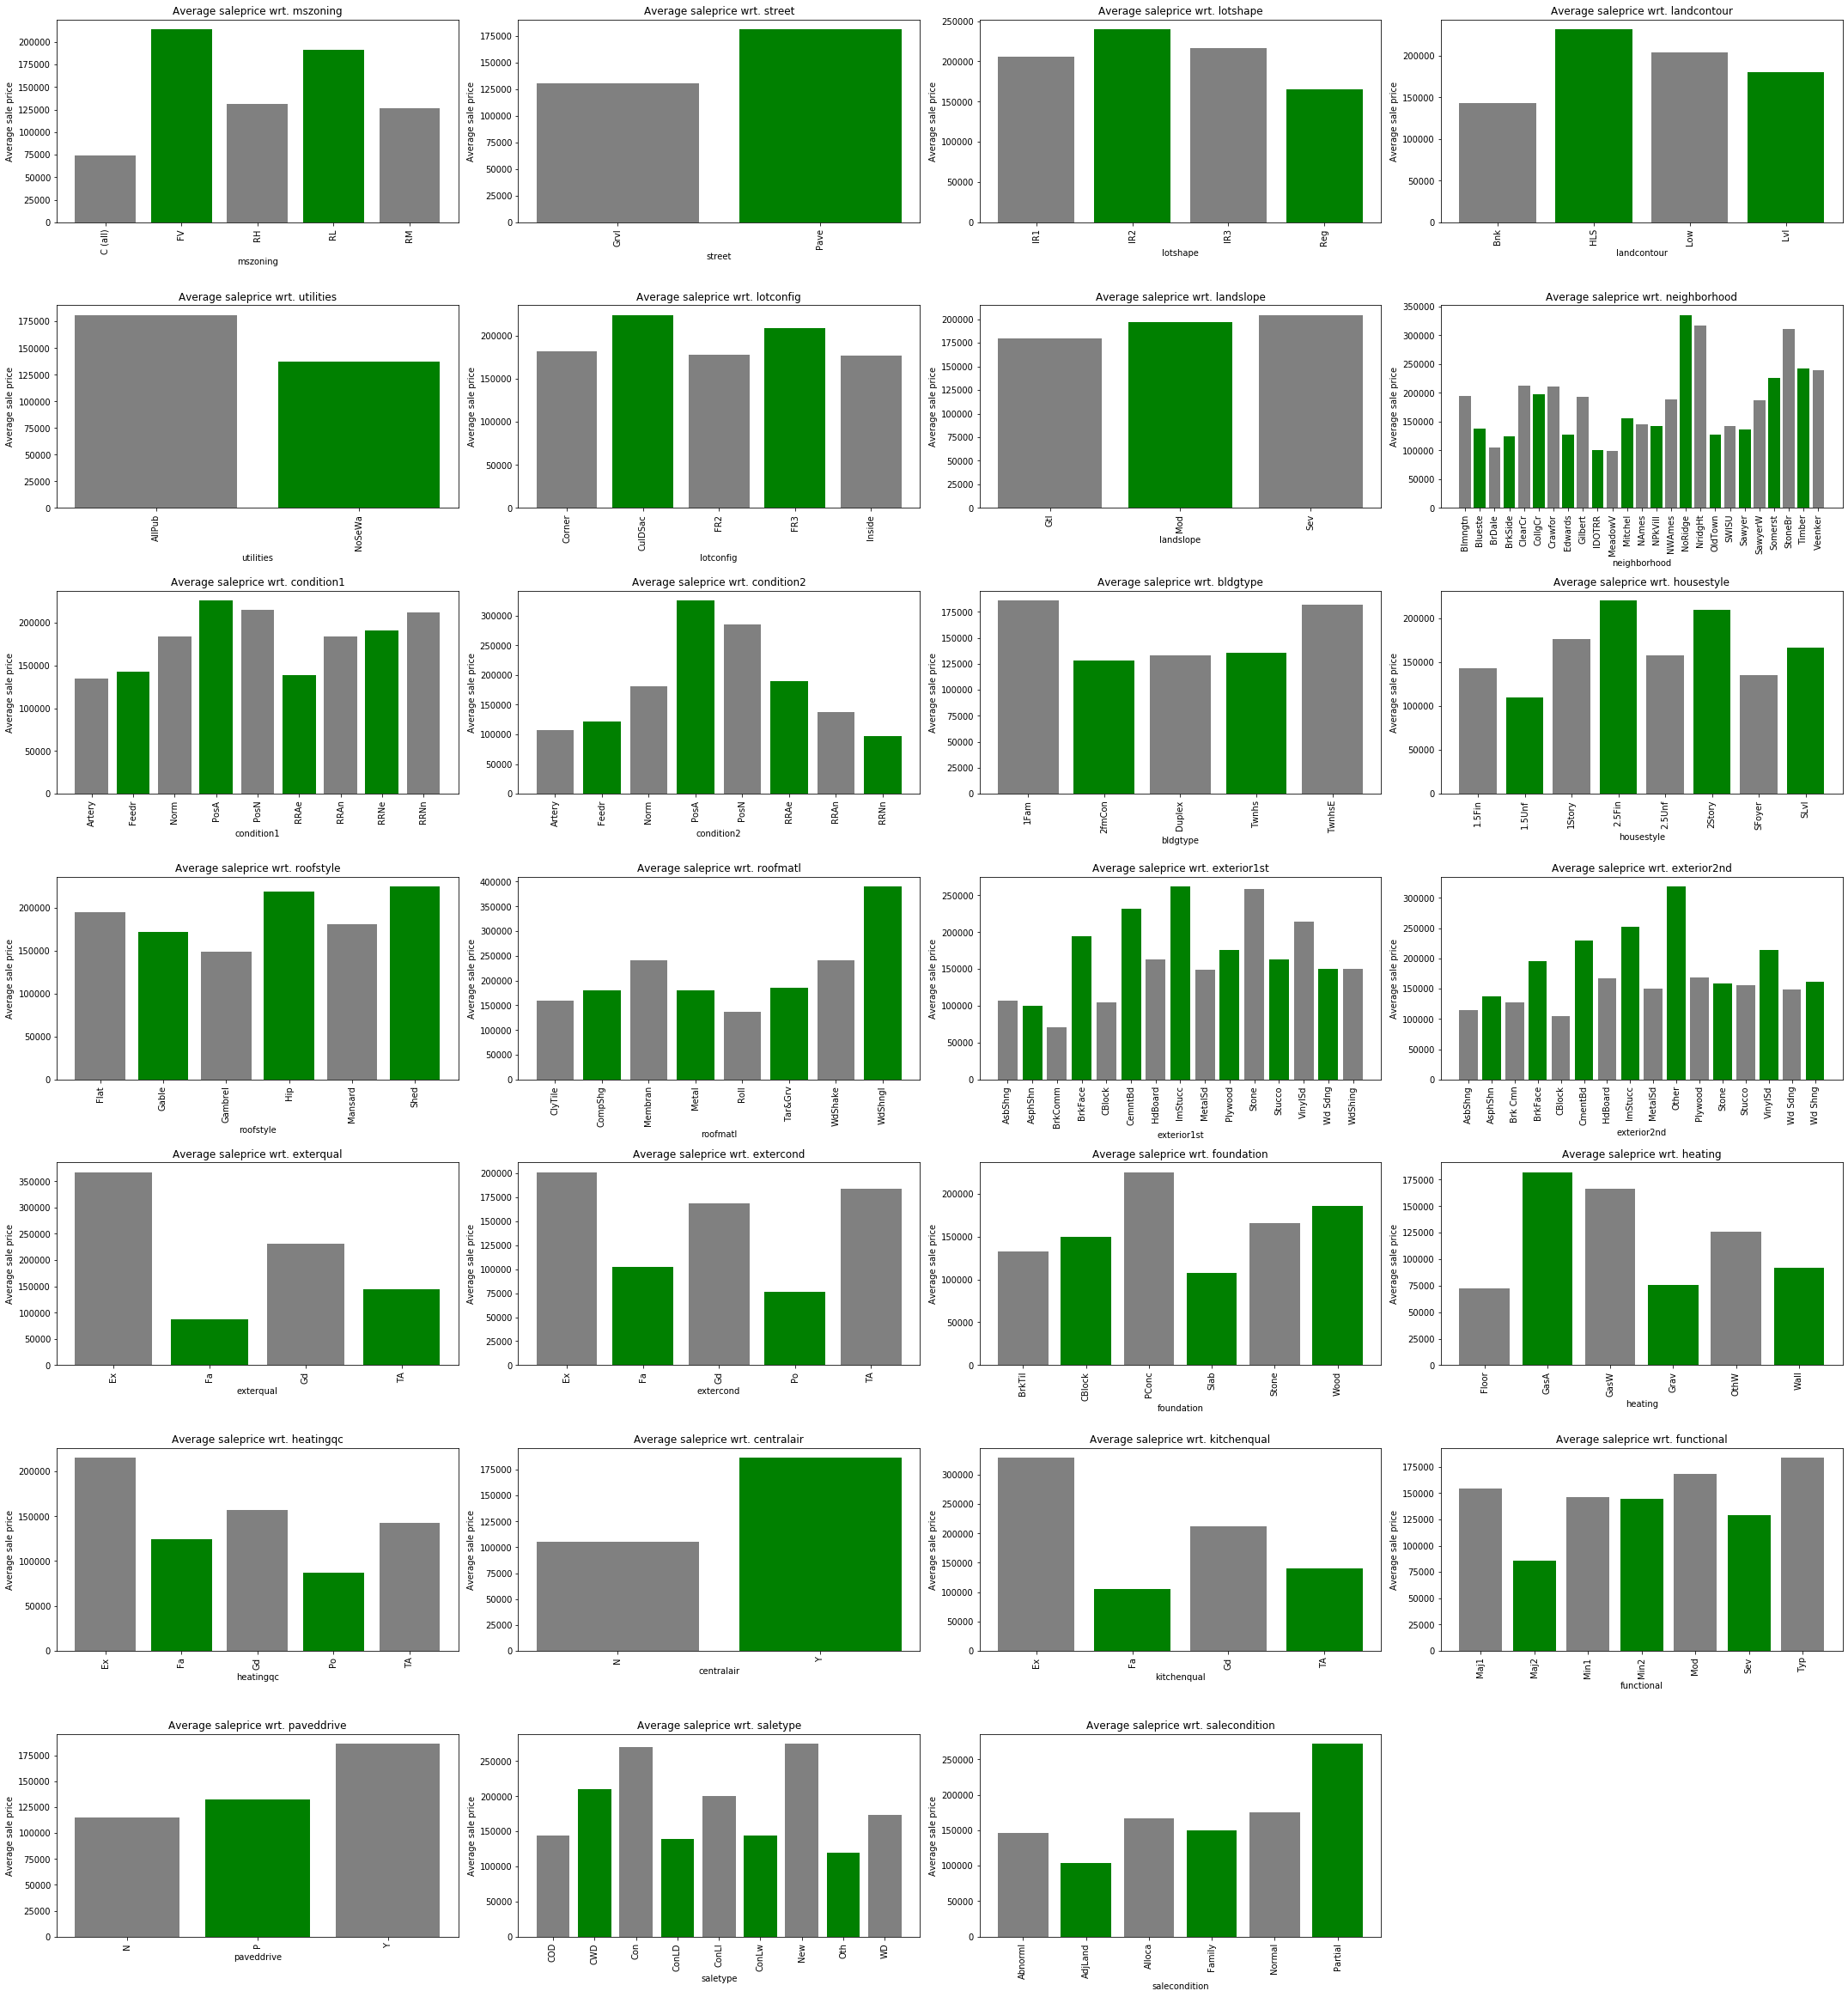

In [0]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Let's take the top 15 numerical and 3 non numerical variables that have a high corelation with the target value.

We will create two new columns that represent the non numerical values with one hot coding through get_dummies.

In [0]:
##One hot coding the 3 non numerical variables.
df = pd.concat([df,pd.get_dummies(df.lotshape, prefix="lotshape", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)
                                
dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names1 = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)
dummy_column_names = dummy_column_names1 + list(pd.get_dummies(df.lotshape, prefix="lotshape", drop_first=True).columns)

## Basic Regression Modeling

In [0]:
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf','openporchsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd', 'fireplaces','bsmtfinsf1', 'wooddecksf', 'secondflrsf'] + dummy_column_names]
Y = df.saleprice

In [0]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     189.0
Date:                Sun, 16 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:59:46   Log-Likelihood:                -13909.
No. Observations:                1168   AIC:                         2.787e+04
Df Residuals:                    1144   BIC:                         2.799e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.072e+05   1.48e+05     -6.144      0.000    -1.2e+06   -6.18e+05
overallqual   2.102e+04   1345.730     15.621      0.000    1.84e+04    2.37e+04
grlivarea       10.8656     21.359      0.509      0.611     -31.041      52.773
garagecars    9787.8906   3395.136      2.883      0.004    3126.499    1.64e+04
garagearea      18.0335     11.367      1.586      0.113      -4.269      40.336
totalbsmtsf     12.6596      4.702      2.692      0.007       3.433      21.886
firstflrsf      27.5012     21.851      1.259      0.208     -15.371      70.374
openporchsf     -4.8357     18.598     -0.260      0.795     -41.325      31.654
fullbath     -1566.3696   2939.494     -0.533      0.594   -7333.774    4201.035
totrmsabvgrd  3303.4005   1264.343      2.613      0.009     822.710    5784.091
yearbuilt      110.9888     58.941      1.883      0.060      -4.656     226.634
yearremodadd   304.4523     69.212      4.399      0.000     168.655     440.249
fireplaces    8008.1127   2003.692      3.997      0.000    4076.790    1.19e+04
bsmtfinsf1      15.1265      2.885      5.242      0.000       9.465      20.788
wooddecksf      27.3584      9.341      2.929      0.003       9.031      45.686
secondflrsf     23.1412     21.401      1.081      0.280     -18.849      65.131
mszoning_FV   9097.5448   1.46e+04      0.621      0.535   -1.96e+04    3.78e+04
mszoning_RH    265.0766   1.64e+04      0.016      0.987    -3.2e+04    3.25e+04
mszoning_RL   9963.3157   1.35e+04      0.741      0.459   -1.64e+04    3.64e+04
mszoning_RM  -1798.0215   1.35e+04     -0.133      0.894   -2.84e+04    2.48e+04
street_Pave   1933.3768   1.67e+04      0.116      0.908   -3.08e+04    3.47e+04
lotshape_IR2  1.828e+04   6240.717      2.929      0.003    6037.570    3.05e+04
lotshape_IR3 -4.784e+04   1.25e+04     -3.834      0.000   -7.23e+04   -2.34e+04
lotshape_Reg -3469.7976   2445.868     -1.419      0.156   -8268.688    1329.093
==============================================================================
Omnibus:                      366.510   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42093.542
Skew:                          -0.305   Prob(JB):                         0.00
Kurtosis:                      32.403   Cond. No.                     5.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We do have a decent R value of 0.792%, which means that there is still room for improvement. In order to increase the goodness of fit of our model: We first log transform the dependent variable. The saleprice variable is not normally distributed, so log transforming may help in this regard. To this end, we apply log(1+x) transformation of NumPy. Second, we create another variable by summing up the basement, first and the second floor areas. Third, we add the interaction of the total area and the overall quality of the house.

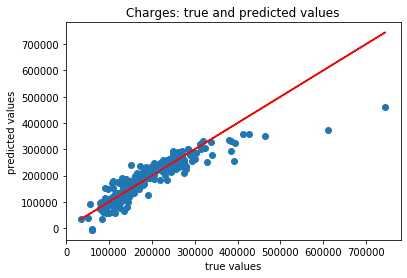

Mean absolute error of the prediction is: 23296.42536785152
Mean squared error of the prediction is: 1346251158.4085753
Root mean squared error of the prediction is: 36691.29540379537
Mean absolute percentage error of the prediction is: 13.933471300737793


In [0]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

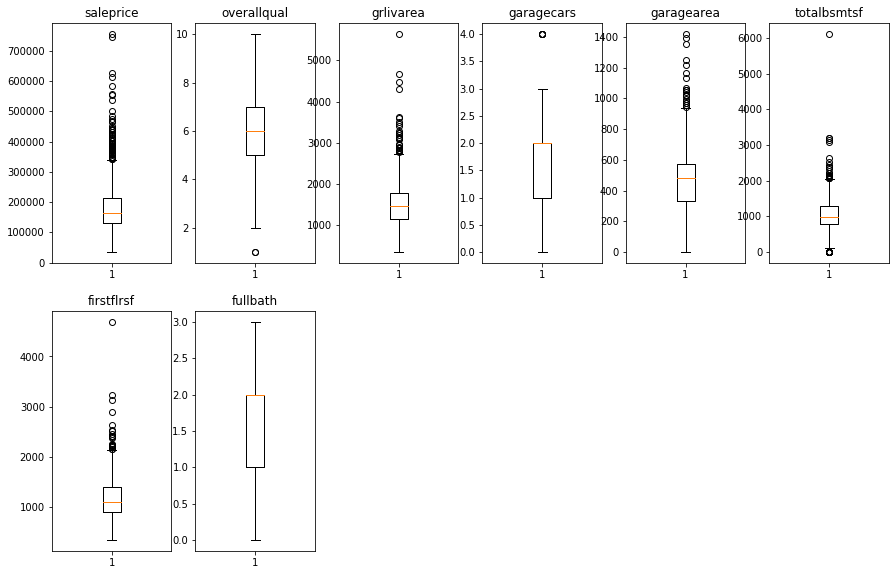

In [0]:
plt.figure(figsize = (15,15))


plt.subplot(3,6,1)
plt.boxplot(df["saleprice"])
plt.title("saleprice")

plt.subplot(3,6,2)
plt.boxplot(df["overallqual"])
plt.title("overallqual")

plt.subplot(3,6,3)
plt.boxplot(df["grlivarea"])
plt.title("grlivarea")

plt.subplot(3,6,4)
plt.boxplot(df["garagecars"])
plt.title("garagecars")

plt.subplot(3,6,5)
plt.boxplot(df["garagearea"])
plt.title("garagearea")

plt.subplot(3,6,6)
plt.boxplot(df["totalbsmtsf"])
plt.title("totalbsmtsf")

plt.subplot(3,6,7)
plt.boxplot(df["firstflrsf"])
plt.title("firstflrsf")

plt.subplot(3,6,8)
plt.boxplot(df["fullbath"])
plt.title("fullbath")

plt.show()

### We can clearly find the outliers in the features. They will affect our analysis so let's take the log transformation (1+x) of numpy for the independent variables or features that we have considered for this model.

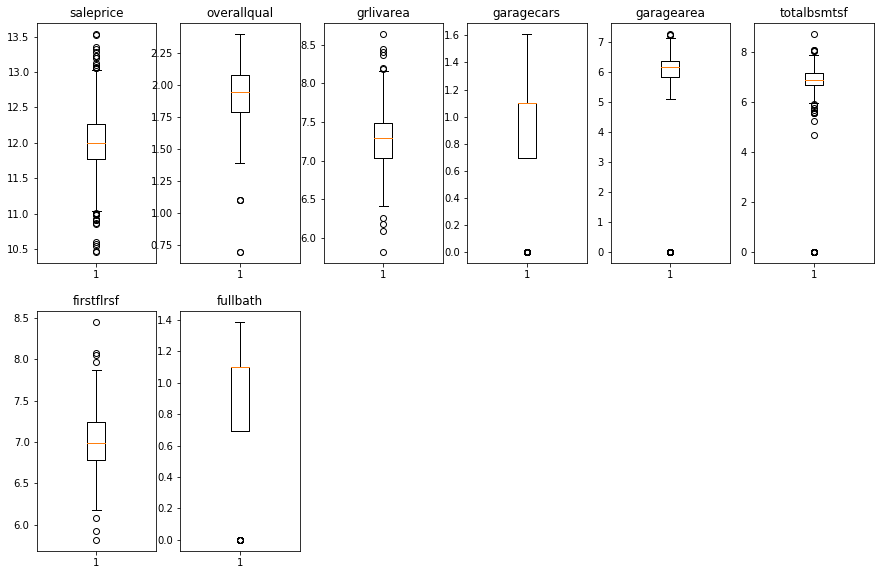

In [0]:
plt.figure(figsize = (15,15))

plt.subplot(3,6,1)
plt.boxplot(np.log1p(df["saleprice"]))
plt.title("saleprice")

plt.subplot(3,6,2)
plt.boxplot(np.log1p(df["overallqual"]))
plt.title("overallqual")

plt.subplot(3,6,3)
plt.boxplot(np.log1p(df["grlivarea"]))
plt.title("grlivarea")

plt.subplot(3,6,4)
plt.boxplot(np.log1p(df["garagecars"]))
plt.title("garagecars")

plt.subplot(3,6,5)
plt.boxplot(np.log1p(df["garagearea"]))
plt.title("garagearea")

plt.subplot(3,6,6)
plt.boxplot(np.log1p(df["totalbsmtsf"]))
plt.title("totalbsmtsf")

plt.subplot(3,6,7)
plt.boxplot(np.log1p(df["firstflrsf"]))
plt.title("firstflrsf")

plt.subplot(3,6,8)
plt.boxplot(np.log1p(df["fullbath"]))
plt.title("fullbath")

plt.show()

#### We can see that the number of outliers have decreased considerably. This way, our model will be much more accurate in predicting the right result.

### Feature Engineering

* Lets create three variables that covers 
* 1) Summing of different floors
* 2) Interaction of two variables

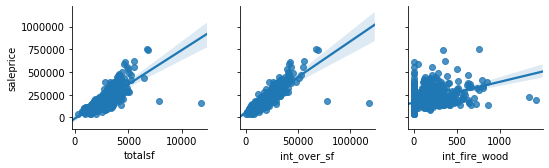

In [0]:
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']
df['int_over_sf'] = df['totalsf'] * df['overallqual']
df['int_fire_wood'] = df['fireplaces'] * df['wooddecksf']


s = sns.pairplot(data=df,
            y_vars = 'saleprice',
            x_vars = ['totalsf', 'int_over_sf', 'int_fire_wood'],kind='reg')

We do see a high correlation of these features with respect to saleprice. We will add them to over model to propose a new improvised model:

# Improved Regression Modeling:

In [0]:
#Creating a new variable total sf that is the sum of basement, first floor and second floor
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

#Creating another new variable that has interaction between two variables.
df['int_over_sf'] = df['totalsf'] * df['overallqual']

#Let's create another interaction to see if there can be more improvement.
df['int_fire_wood'] = df['fireplaces'] * df['wooddecksf']
# Y is the target variable
Y = np.log1p(df['saleprice'])
# X is the feature set
X = np.log1p(df[['totalsf', 'int_over_sf', 'int_fire_wood','overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf','openporchsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd', 'fireplaces','bsmtfinsf1', 'wooddecksf', 'secondflrsf'] + dummy_column_names])

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     283.7
Date:                Sun, 16 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:59:48   Log-Likelihood:                 595.82
No. Observations:                1168   AIC:                            -1138.
Df Residuals:                    1141   BIC:                            -1001.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -41.8784      4.742     -8.831      0.000     -51.183     -32.574
totalsf           2.7471      0.432      6.355      0.000       1.899       3.595
int_over_sf      -2.4357      0.421     -5.782      0.000      -3.262      -1.609
int_fire_wood    -0.0052      0.003     -1.563      0.118      -0.012       0.001
overallqual       3.5082      0.504      6.958      0.000       2.519       4.498
grlivarea         0.2206      0.077      2.871      0.004       0.070       0.371
garagecars        0.1766      0.034      5.235      0.000       0.110       0.243
garagearea       -0.0067      0.006     -1.031      0.303      -0.019       0.006
totalbsmtsf      -0.0115      0.009     -1.301      0.193      -0.029       0.006
firstflrsf       -0.0173      0.057     -0.303      0.762      -0.129       0.095
openporchsf       0.0016      0.002      0.679      0.498      -0.003       0.006
fullbath         -0.0451      0.029     -1.535      0.125      -0.103       0.013
totrmsabvgrd      0.0552      0.039      1.402      0.161      -0.022       0.133
yearbuilt         1.1958      0.481      2.488      0.013       0.253       2.139
yearremodadd      5.0074      0.564      8.872      0.000       3.900       6.115
fireplaces        0.0906      0.016      5.555      0.000       0.059       0.123
bsmtfinsf1        0.0134      0.002      8.317      0.000       0.010       0.017
wooddecksf        0.0074      0.003      2.813      0.005       0.002       0.012
secondflrsf      -0.0056      0.005     -1.127      0.260      -0.015       0.004
mszoning_FV       0.5005      0.087      5.784      0.000       0.331       0.670
mszoning_RH       0.3764      0.097      3.875      0.000       0.186       0.567
mszoning_RL       0.4575      0.080      5.744      0.000       0.301       0.614
mszoning_RM       0.3144      0.080      3.929      0.000       0.157       0.471
street_Pave      -0.1163      0.098     -1.193      0.233      -0.308       0.075
lotshape_IR2      0.0881      0.036      2.420      0.016       0.017       0.160
lotshape_IR3     -0.2176      0.072     -3.024      0.003      -0.359      -0.076
lotshape_Reg     -0.0331      0.014     -2.315      0.021      -0.061      -0.005
==============================================================================
Omnibus:                      405.560   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4265.604
Skew:                          -1.291   Prob(JB):                         0.00
Kurtosis:                      11.999   Cond. No.                     2.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+04. T

R-squared and adjusted R-squared of the model are 0.869 and 0.866 respectively. These are improvements upon the first model. **F statistic** and its associated **p-value are 364.2 and 0.00** respectively. This also indicates that the second model is better than the first one. **AIC and BIC of the model are -1448 and -1305** respectively. These values are lower than the ones of the first model. Hence, the **second model is better than the first model**. Considering all of the metrics above, our second model has a better goodness of fit than the first model.

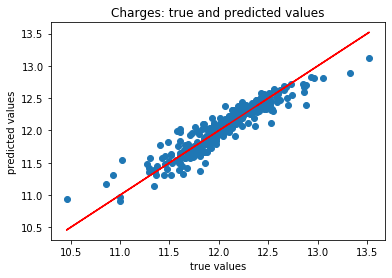

Mean absolute error of the prediction is: 0.10695750752506222
Mean squared error of the prediction is: 0.021158947358784666
Root mean squared error of the prediction is: 0.14546115412296393
Mean absolute percentage error of the prediction is: 0.8935158465187298


In [0]:
# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

For MAE, MSE, RMSE and MAPE the values have considerably reduced. Which means that our improvised model performs much better than the other regression model.

#### Linear Regression

In [0]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8660527685344512
-----Test set statistics-----
R-squared of the model in test set is: 0.8731064497999355
Mean absolute error of the prediction is: 0.10695750752511034
Mean squared error of the prediction is: 0.021158947358789315
Root mean squared error of the prediction is: 0.1454611541229799
Mean absolute percentage error of the prediction is: 0.8935158465191002


#### Lasso regression

In [0]:
## 10** (p-values from -10 to 40)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-09
R-squared of the model in training set is: 0.8644653968601708
-----Test set statistics-----
R-squared of the model in test set is: 0.8734390952813417
Mean absolute error of the prediction is: 0.10750421607045488
Mean squared error of the prediction is: 0.021103480172166227
Root mean squared error of the prediction is: 0.14527036921604566
Mean absolute percentage error of the prediction is: 0.8974882392995632


#### Ridge regression

In [0]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.8656769210107275
-----Test set statistics-----
R-squared of the model in test set is: 0.8738951417758056
Mean absolute error of the prediction is: 0.10737896861682064
Mean squared error of the prediction is: 0.02102743640355616
Root mean squared error of the prediction is: 0.1450084011481961
Mean absolute percentage error of the prediction is: 0.8969062429389496


#### Elastic regresssion

In [0]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-08
R-squared of the model in training set is: 0.8644652010784301
-----Test set statistics-----
R-squared of the model in test set is: 0.8734382445605708
Mean absolute error of the prediction is: 0.10750445763792454
Mean squared error of the prediction is: 0.02110362202615312
Root mean squared error of the prediction is: 0.14527085745652196
Mean absolute percentage error of the prediction is: 0.89749031963546


# Evaluation

The model was analysed with different regression models. We were able to find the highest R values in Linear regression and Ridge regression. The values did not vary much from the other models. We will now try to include other factors that could possibly affect our model.

### Cross Validation with k-fold:


In [0]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=40)
clf = LinearRegression()
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.86263541 0.9052068  0.76246503 0.88240342 0.8404243 ]
Mean cross validatiion score: 0.851


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=40)
clf = LassoCV(alphas=alphas, cv=5)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.8572674  0.89971158 0.76925516 0.88927591 0.83641793]
Mean cross validatiion score: 0.850


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=40)
clf = RidgeCV(alphas=alphas, cv=5)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.86060581 0.90315065 0.7662251  0.88616136 0.8396577 ]
Mean cross validatiion score: 0.851


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=40)
clf =  ElasticNetCV(alphas=alphas, cv=5)
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.84045076 0.89971158 0.76928617 0.88927592 0.83642257]
Mean cross validatiion score: 0.847


**The main factors that affect the housing price rate are the economic growth, interest rate, unemployment rate. With the help of datasets available online, we will create two new variables that has information about the interest rates and the unemployment rates for the respective years. Let's find out the duration in which this dataset was recorded, then we will get the interest rates and the unemployment for those years.**

In [0]:
'TThe sales were made between the years {} and {}.'.format(min(df['yrsold']),max(df['yrsold']))

'TThe sales were made between the years 2006 and 2010.'

**The unemployment data was taken from [Bureau of Labor Statistics](https://data.bls.gov/pdq/SurveyOutputServlet).
Below is the graph taken from the website that shows the unemployment rate over the years from 2006 to 2011.**

**The interest rates of the United States was taken from the [world bank data](https://data.worldbank.org/indicator/FR.INR.RINR?locations=US).**

![unemployment.gif](attachment:unemployment.gif)

In [0]:
unemployment_rate = [4.7,4.6,5.0,7.8,9.8]
int_rate = [4.786, 5.223, 3.082, 2.469, 2.061]

def unemployment(row):
   if row['yrsold'] == 2006 :
      return 4.7
   if row['yrsold'] == 2007 :
      return 4.6
   if row['yrsold'] == 2008:
      return 5.0
   if row['yrsold']  == 2009:
      return 7.8
   if row['yrsold'] == 2010:
      return 9.8
df["unemployment_rate"]=df.apply (lambda row: unemployment(row), axis=1)

In [0]:
def int_rate(row):
   if row['yrsold'] == 2006 :
      return 4.786
   if row['yrsold'] == 2007 :
      return 5.223
   if row['yrsold'] == 2008:
      return 3.082
   if row['yrsold']  == 2009:
      return 2.469
   if row['yrsold'] == 2010:
      return 2.061
df["int_rate"]=df.apply (lambda row: unemployment(row), axis=1)

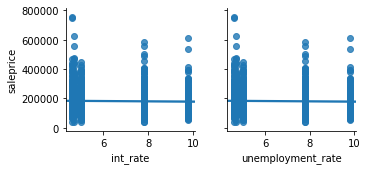

In [0]:
s = sns.pairplot(data=df,
            y_vars = 'saleprice',
            x_vars = ['int_rate','unemployment_rate'],kind='reg')

We do see that the saleprice is much higher with less interest rate and similarly with unemployment rate, the sale price seems higher in lesser unemployment rate. We will check if add these two variables have affected our basic model.

In [0]:
# Y is the target variable
Y = np.log1p(df['saleprice'])
# X is the feature set
X = np.log1p(df[['unemployment_rate','int_rate','overallqual','grlivarea','garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf']])

import statsmodels.api as sm

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     674.4
Date:                Sun, 16 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:59:54   Log-Likelihood:                 369.80
No. Observations:                1168   AIC:                            -723.6
Df Residuals:                    1160   BIC:                            -683.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.2446      0.154     40.467      0.000       5.942       6.547
unemployment_rate    -0.0013      0.011     -0.125      0.901      -0.022       0.020
int_rate             -0.0013      0.011     -0.125      0.901      -0.022       0.020
overallqual           0.8626      0.038     22.766      0.000       0.788       0.937
grlivarea             0.3081      0.022     14.262      0.000       0.266       0.351
garagecars            0.3437      0.037      9.389      0.000       0.272       0.415
garagearea           -0.0262      0.007     -3.642      0.000      -0.040      -0.012
totalbsmtsf           0.0243      0.005      5.067      0.000       0.015       0.034
firstflrsf            0.2173      0.020     10.799      0.000       0.178       0.257
==============================================================================
Omnibus:                      286.860   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.443
Skew:                          -1.076   Prob(JB):                    8.33e-287
Kurtosis:                       7.738   Cond. No.                     7.15e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.47e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### As you can see there has been an improvement in the basic model when including the interest rate and unemployment rate in the data. The R value increased from 0.792 to 0.803. Now lets do the regression analysis on this model. The F-statistics has increased from 189 to 674.4

In [0]:
#Creating a new variable total sf that is the sum of basement, first floor and second floor
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

#Creating another new variable that has interaction between two variables.
df['int_over_sf'] = df['totalsf'] * df['overallqual']

#Let's create another interaction to see if there can be more improvement.
df['int_fire_wood'] = df['fireplaces'] * df['wooddecksf']

# Y is the target variable
Y = np.log1p(df['saleprice'])
# X is the feature set
X = np.log1p(df[['unemployment_rate','int_rate','totalsf', 'int_over_sf', 'int_fire_wood','overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf','openporchsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd', 'fireplaces','bsmtfinsf1', 'wooddecksf', 'secondflrsf'] + dummy_column_names])

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     273.6
Date:                Sun, 16 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:59:54   Log-Likelihood:                 596.87
No. Observations:                1168   AIC:                            -1138.
Df Residuals:                    1140   BIC:                            -996.0
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -42.0763      4.742     -8.873      0.000     -51.380     -32.772
unemployment_rate    -0.0128      0.009     -1.432      0.152      -0.030       0.005
int_rate             -0.0128      0.009     -1.432      0.152      -0.030       0.005
totalsf               2.7464      0.432      6.356      0.000       1.899       3.594
int_over_sf          -2.4295      0.421     -5.770      0.000      -3.256      -1.603
int_fire_wood        -0.0054      0.003     -1.610      0.108      -0.012       0.001
overallqual           3.4989      0.504      6.942      0.000       2.510       4.488
grlivarea             0.2195      0.077      2.858      0.004       0.069       0.370
garagecars            0.1751      0.034      5.192      0.000       0.109       0.241
garagearea           -0.0064      0.006     -0.983      0.326      -0.019       0.006
totalbsmtsf          -0.0122      0.009     -1.379      0.168      -0.030       0.005
firstflrsf           -0.0203      0.057     -0.355      0.722      -0.132       0.092
openporchsf           0.0015      0.002      0.630      0.529      -0.003       0.006
fullbath             -0.0453      0.029     -1.542      0.123      -0.103       0.012
totrmsabvgrd          0.0547      0.039      1.390      0.165      -0.023       0.132
yearbuilt             1.1856      0.480      2.468      0.014       0.243       2.128
yearremodadd          5.0500      0.565      8.939      0.000       3.942       6.158
fireplaces            0.0912      0.016      5.594      0.000       0.059       0.123
bsmtfinsf1            0.0134      0.002      8.333      0.000       0.010       0.017
wooddecksf            0.0075      0.003      2.878      0.004       0.002       0.013
secondflrsf          -0.0057      0.005     -1.153      0.249      -0.015       0.004
mszoning_FV           0.5002      0.086      5.783      0.000       0.330       0.670
mszoning_RH           0.3725      0.097      3.836      0.000       0.182       0.563
mszoning_RL           0.4562      0.080      5.729      0.000       0.300       0.612
mszoning_RM           0.3126      0.080      3.908      0.000       0.156       0.470
street_Pave          -0.1148      0.098     -1.178      0.239      -0.306       0.076
lotshape_IR2          0.0886      0.036      2.436      0.015       0.017       0.160
lotshape_IR3         -0.2206      0.072     -3.066      0.002      -0.362      -0.079
lotshape_Reg         -0.0328      0.014     -2.299      0.022      -0.061      -0.005
==============================================================================
Omnibus:                      405.202   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4311.275
Skew:                          -1.286   Prob(JB):                         0.00
Kurtosis:      

Let's try this model with the top 2 of highest accurate models from the previos analysis.
### Linear regression

In [0]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8662932654420233
-----Test set statistics-----
R-squared of the model in test set is: 0.8742910605046053
Mean absolute error of the prediction is: 0.10668168717096416
Mean squared error of the prediction is: 0.0209614186782437
Root mean squared error of the prediction is: 0.14478058805739014
Mean absolute percentage error of the prediction is: 0.8911430271665861


The results have slightly improved.
### Ridge regression

In [0]:
## 10** (p-values from -10 to 40)
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.8659156849083054
-----Test set statistics-----
R-squared of the model in test set is: 0.8749628396917053
Mean absolute error of the prediction is: 0.10710896039582357
Mean squared error of the prediction is: 0.020849402421829026
Root mean squared error of the prediction is: 0.1443932215231346
Mean absolute percentage error of the prediction is: 0.8946054859470032


The ridge regression of the previous model gave better results.

# SUMMARY

We were able to use external features and alter the dataframe to improve the model and arrive with better results. The Ridge regression had the highest accuracy and R value of 0.869.

* Loaded the houseprices data from Thinkful's database.
* Did data cleaning, exploratory data analysis, and feature engineering.
* split the data into train and test sets where 20% of the data resides in the test set.
* Built several linear regression models including Lasso, Ridge, or ElasticNet and trained them in the training set. Used k-fold cross-validation to select the best hyperparameters.
* Evaluated the best model on the test set.
* found some useful factors that were not included in the dataset. Integrated these factors into the model and assessed the prediction performance of the model.